In [117]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgbm
import catboost
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler, Normalizer
from imblearn.over_sampling import SMOTE

In [118]:
train = pd.read_csv('train.csv')

In [119]:
test = pd.read_csv('test.csv')

In [120]:
len(train)

2056

In [121]:
train.dtypes

Id                        int64
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

## Original dataset

In [122]:
og_dataset = pd.read_csv('WineQT.csv')

In [123]:
# Concatenating train with og_dataset

In [124]:
train = pd.concat([train,og_dataset])

In [125]:
len(train)

3199

## Values taken by the features are not that many... maybe consider treating some of the features as categorical variables? 

In [126]:
train.nunique()

Id                      2056
fixed acidity             92
volatile acidity         136
citric acid               77
residual sugar            84
chlorides                132
free sulfur dioxide       53
total sulfur dioxide     138
density                  397
pH                        88
sulphates                 89
alcohol                   62
quality                    6
dtype: int64

In [127]:
# train set is highly imbalanced with very few examples of 4/3/8 qualitites 
train['quality'].value_counts()/len(train['quality'])*100

5    41.325414
6    38.762113
7    14.879650
4     2.750860
8     1.719287
3     0.562676
Name: quality, dtype: float64

## Some data plotting : Many of the features seem to be quite useful for classification. Even id seems to be playing a role ! 

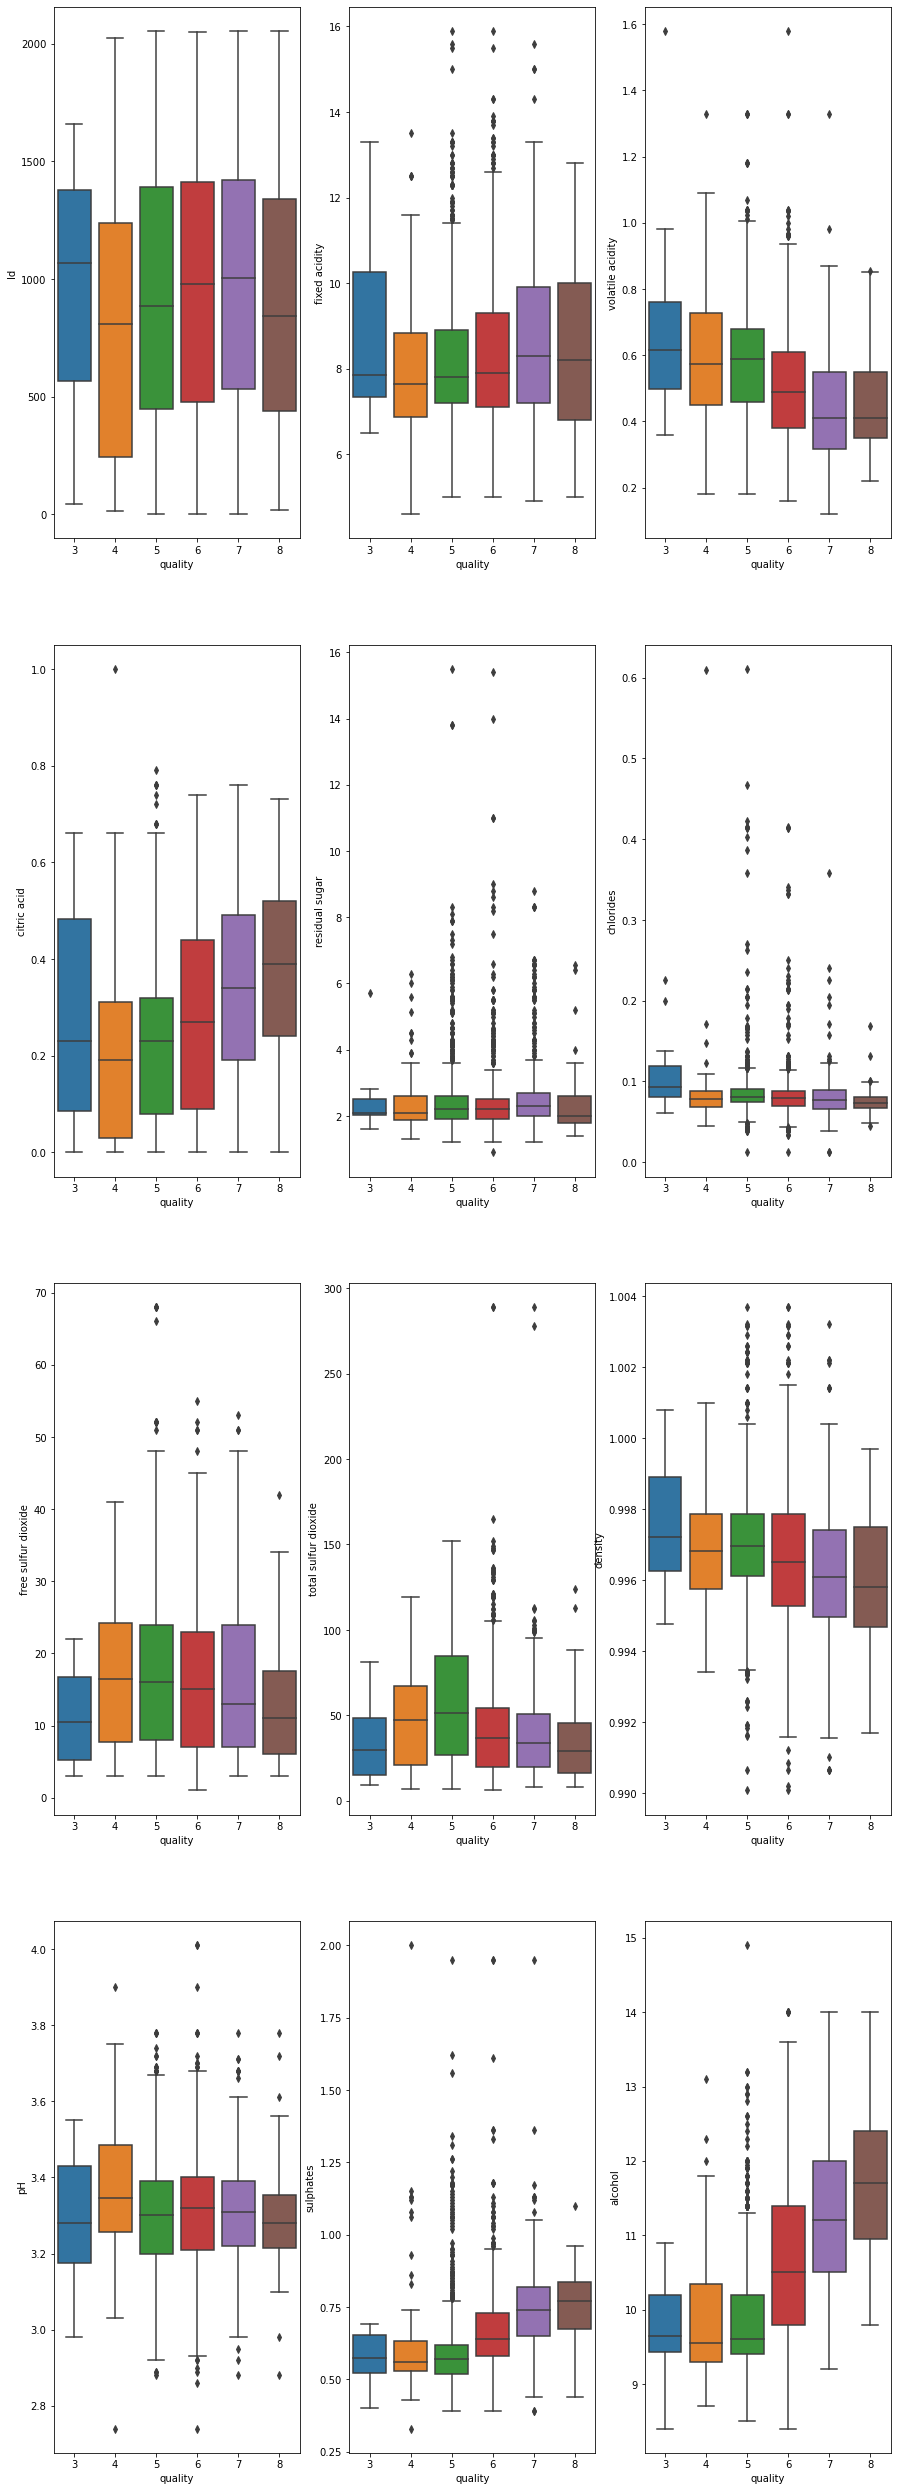

In [12]:
og_features = [c for c in train if 'quality' not in c]
ncols = 3
nrows = int(np.ceil(len(og_features)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 45))

for i in range(len(og_features)):
    j = i%3
    k = int(i/3)
    sns.boxplot(ax = axes [k,j], x = 'quality', y = og_features[i],data = train)

## Many features have high correlation (acidity with ph for example)

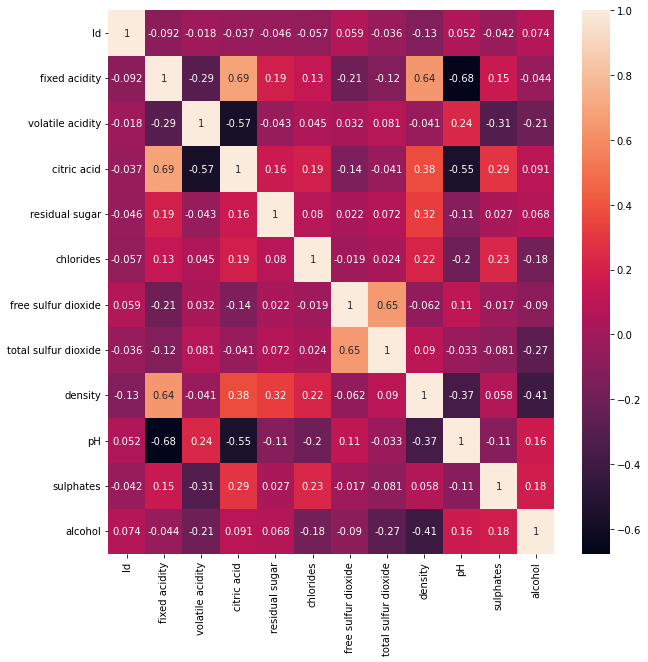

In [13]:
# Seeing if any of the features are correlated
plt.figure(figsize=(10,10))
sns.heatmap(train[og_features].corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

## And also densities. Quite useful to have a feeling of what is happening. Many of the features do not have normal distribution. Maybe useful to pre-process for better performance

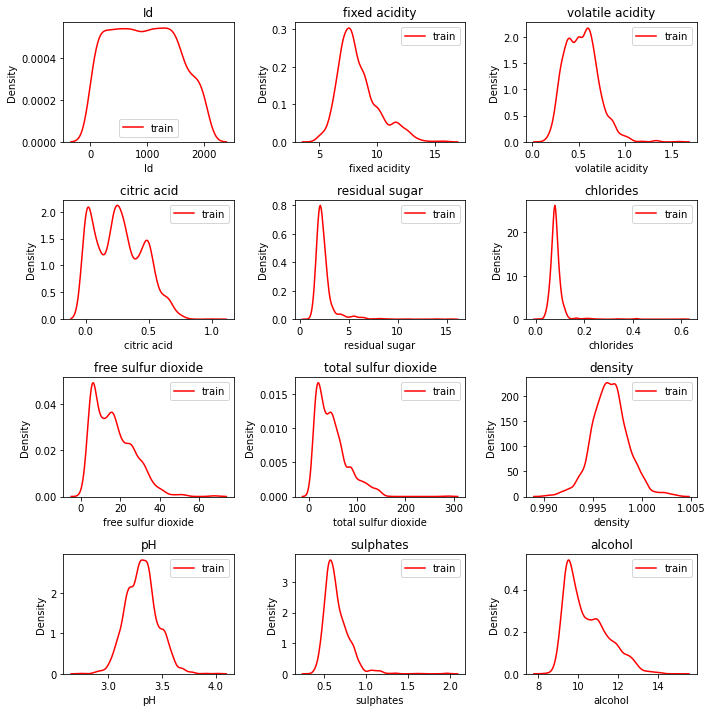

In [14]:
ncols = 3
nrows = int(np.ceil(len(og_features)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
for ax, f in zip(axes.flat, og_features):
    sns.kdeplot(train[f], color='r', label='train', ax=ax)
    ax.set_title(f)
    ax.legend()
plt.tight_layout()
plt.show()

## Feature engineering : None for now. Let's just try to submit something fast.

In [15]:
# Trying the same but scaling the features first 
#RS = RobustScaler()
#train[og_features] = RS.fit_transform(train[og_features])

In [16]:
#NMZ = Normalizer()
#train[og_features] = NMZ.fit_transform(train[og_features])

In [17]:
og_dataset.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'Id'],
      dtype='object')

In [128]:
def add_features(train):
    train = train.copy()
    train['free_sulfur_dioxide_%'] = train['free sulfur dioxide']/train['total sulfur dioxide']*100
    train['sulphates_2_alcohol'] = train['sulphates']/train['alcohol']
    train['sugar_2_alcohol'] = train['residual sugar']/train['alcohol']
    train['acidity_2_alcohol'] = train['fixed acidity']/train['alcohol']
    train['chlorides_2_alcohol'] = train['chlorides']/train['alcohol']
    train['density_2_alcohol'] = train['density']/train['alcohol']
    return train 

In [129]:
train = add_features(train)

In [130]:
features = [c for c in train if c!='quality']

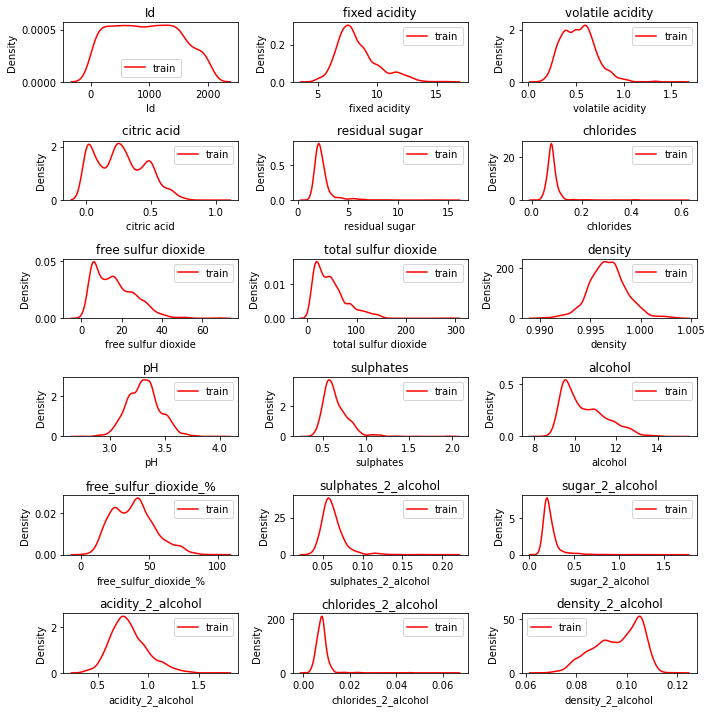

In [131]:
ncols = 3
nrows = int(np.ceil(len(features)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
for ax, f in zip(axes.flat, features):
    sns.kdeplot(train[f], color='r', label='train', ax=ax)
    ax.set_title(f)
    ax.legend()
plt.tight_layout()
plt.show()

In [132]:
#features = [c for c in og_features if c not in ['Id']]


In [133]:
train['quality_target'] = train['quality']-3

In [134]:
target = 'quality_target'

# Fitting a model : first try, XGBoost

In [186]:
# splitting train and validation 
# Splitting training set - startified to get a good repartition of Attrition everywhere 
x = train[features]
y = train[target]
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.05, stratify = y)

RS = RobustScaler()
x_train = pd.DataFrame(RS.fit_transform(x_train), columns = x_train.columns)

x_validation = pd.DataFrame(RS.fit_transform(x_validation), columns = x_validation.columns)

<AxesSubplot: xlabel='quality'>

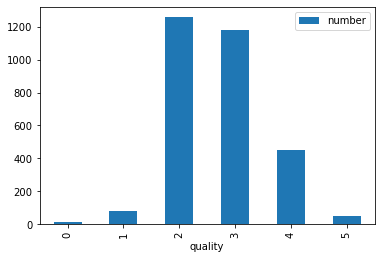

In [187]:
y_train.value_counts().reset_index().rename(columns= {'index':'quality','quality_target':'number'}).sort_values(by='quality').plot.bar(x='quality')

In [77]:
y_train.value_counts().reset_index().rename(columns= {'index':'quality','quality_target':'number'}).sort_values(by='quality')

,quality,number
5,0,17
3,1,84
0,2,1256
1,3,1178
2,4,452
4,5,52


In [78]:
strategy = {0:200, 1:200, 2:1256, 3:1178, 4:500, 5:200}
oversample = SMOTE(sampling_strategy=strategy)
#x_train, y_train = oversample.fit_resample(x_train, y_train)

<AxesSubplot: xlabel='quality'>

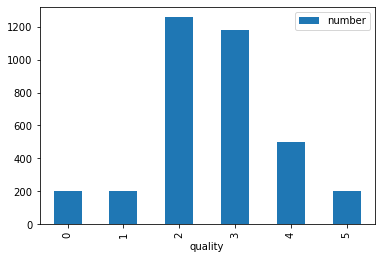

In [79]:
y_train.value_counts().reset_index().rename(columns= {'index':'quality','quality_target':'number'}).sort_values(by='quality').plot.bar(x='quality')

## Let's define a function that will compute the quadratic weighted kappa

In [137]:
# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 'kappa',(1.0 - numerator / denominator)

In [50]:
# defining an xgboost regressor
# regularisation parameters were found through trial and error. can probably be improved
xg_reg = xgb.XGBClassifier(
            objective='multi:softmax',
            num_class = 6,
            tree_method="hist",
            n_estimators=2000,
            learning_rate=0.0075,
            reg_lambda = 0.3,
            reg_alpha = 0.2,
            max_leaves = 17,
            subsample=0.50,
            colsample_bytree=0.50,
            max_bin=4096,
            n_jobs=2,
            feval=quadratic_weighted_kappa,
            #eval_metric = quadratic_weighted_kappa,
            #eval_metric='auc',
            early_stopping_rounds=70,
        )
xg_reg.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_validation,y_validation)],verbose=200)

[0]	validation_0-mlogloss:1.78574	validation_1-mlogloss:1.78862
[200]	validation_0-mlogloss:1.16565	validation_1-mlogloss:1.43451
[400]	validation_0-mlogloss:0.91853	validation_1-mlogloss:1.28506
[600]	validation_0-mlogloss:0.77494	validation_1-mlogloss:1.19520
[800]	validation_0-mlogloss:0.67459	validation_1-mlogloss:1.13041
[1000]	validation_0-mlogloss:0.59734	validation_1-mlogloss:1.08359
[1200]	validation_0-mlogloss:0.53497	validation_1-mlogloss:1.04616
[1400]	validation_0-mlogloss:0.48186	validation_1-mlogloss:1.01537
[1600]	validation_0-mlogloss:0.43824	validation_1-mlogloss:0.99325
[1800]	validation_0-mlogloss:0.40078	validation_1-mlogloss:0.97416
[1999]	validation_0-mlogloss:0.36796	validation_1-mlogloss:0.95890


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=70, enable_categorical=False,
              eval_metric=None,
              feval=<function quadratic_weighted_kappa at 0x150cb0430>, gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0075, max_bin=4096,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=17,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=2, num_class=6, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', ...)

## Grid search on XGBoost parameters to try and find better


In [85]:
cv_params = {'max_depth':[6,10,15],'max_leaves':[10,20,30]}    # parameters to be tried in the grid search
fix_params = {'learning_rate':0.0075,'tree_method':'hist','n_estimators': 4000,'early_stopping_rounds':70 ,'objective': 'multi:softmax','num_class' : 6,
              'subsample':0.5,'colsample_bytree':0.5,'max_bin':4096,'n_jobs':2,'lambda':0.3,'alpha':0.2}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = quadratic_weighted_kappa, cv = 2)

In [86]:
csv.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_validation,y_validation)],verbose=1000)

[0]	validation_0-mlogloss:1.78581	validation_1-mlogloss:1.78572
[896]	validation_0-mlogloss:0.86934	validation_1-mlogloss:1.04663
[0]	validation_0-mlogloss:1.78594	validation_1-mlogloss:1.78569


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: quadratic_weighted_kappa() takes 2 positional arguments but 3 were given

  warnings.warn(


[1000]	validation_0-mlogloss:0.85137	validation_1-mlogloss:1.01641
[1159]	validation_0-mlogloss:0.81936	validation_1-mlogloss:1.01583
[0]	validation_0-mlogloss:1.78521	validation_1-mlogloss:1.78563
[889]	validation_0-mlogloss:0.75615	validation_1-mlogloss:1.04270
[0]	validation_0-mlogloss:1.78528	validation_1-mlogloss:1.78569
[986]	validation_0-mlogloss:0.72497	validation_1-mlogloss:1.00622
[0]	validation_0-mlogloss:1.78503	validation_1-mlogloss:1.78590
[869]	validation_0-mlogloss:0.71781	validation_1-mlogloss:1.04528
[0]	validation_0-mlogloss:1.78500	validation_1-mlogloss:1.78562
[994]	validation_0-mlogloss:0.67481	validation_1-mlogloss:1.00340
[0]	validation_0-mlogloss:1.78581	validation_1-mlogloss:1.78572
[897]	validation_0-mlogloss:0.86848	validation_1-mlogloss:1.04630
[0]	validation_0-mlogloss:1.78594	validation_1-mlogloss:1.78569
[1000]	validation_0-mlogloss:0.85076	validation_1-mlogloss:1.01566
[1159]	validation_0-mlogloss:0.81867	validation_1-mlogloss:1.01519
[0]	validation_0-m

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.10/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


[1000]	validation_0-mlogloss:0.78688	validation_1-mlogloss:1.02196
[1364]	validation_0-mlogloss:0.70051	validation_1-mlogloss:1.01878


GridSearchCV(cv=2,
             estimator=XGBClassifier(alpha=0.2, base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     early_stopping_rounds=70,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None, lambda=0.3,
                                     learning_rate=0.0075...in=4096,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=4000, n_jobs=2, num_class=6,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             param_grid={'max_depth': [6, 10, 15], 'max_leaves': [10, 20, 30]},
             scoring=<function quadratic_weighted_kappa at 0x150cb05e0>)

In [87]:
csv.best_params_

{'max_depth': 6, 'max_leaves': 10}

In [88]:
for key in csv.best_params_:
    fix_params[key] = csv.best_params_[key]

In [188]:
xg_classifier = xgb.XGBClassifier(**fix_params)
xg_classifier.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_validation,y_validation)],verbose=200)

[0]	validation_0-mlogloss:1.78335	validation_1-mlogloss:1.78402
[200]	validation_0-mlogloss:1.09954	validation_1-mlogloss:1.18027
[400]	validation_0-mlogloss:0.91488	validation_1-mlogloss:1.05205
[600]	validation_0-mlogloss:0.82712	validation_1-mlogloss:1.01481
[800]	validation_0-mlogloss:0.76748	validation_1-mlogloss:1.00352
[978]	validation_0-mlogloss:0.72540	validation_1-mlogloss:1.00183


XGBClassifier(alpha=0.2, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=70, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', lambda=0.3,
              learning_rate=0.0075, max_bin=4096, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=10, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=4000,
              n_jobs=2, num_class=6, num_parallel_tree=1,
              objective='multi:softmax', ...)

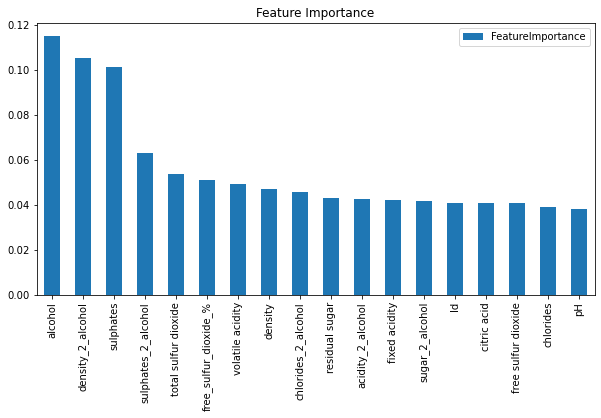

In [189]:
fi =pd.DataFrame(data=xg_classifier.feature_importances_,index=xg_classifier.feature_names_in_,columns=['FeatureImportance']).sort_values(by='FeatureImportance',ascending=False)
fi.plot.bar(title='Feature Importance',figsize=(10,5))
plt.show()

# Regression Model Instead of Classification 

In [190]:
# defining an xgboost regressor
# regularisation parameters were found through trial and error. can probably be improved
xg_reg = xgb.XGBRegressor(
            objective='reg:pseudohubererror',
            tree_method="hist",
            n_estimators=2000,
            learning_rate=0.0075,
            reg_lambda = 0.3,
            reg_alpha = 0.2,
            max_leaves = 10,
            subsample=0.50,
            colsample_bytree=0.50,
            max_bin=4096,
            n_jobs=2,
            feval=quadratic_weighted_kappa,
            #eval_metric = quadratic_weighted_kappa,
            #eval_metric='auc',
            early_stopping_rounds=70,
            max_depth = 6,
        )
xg_reg.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_validation,y_validation)],verbose=200)

[0]	validation_0-mphe:1.38244	validation_1-mphe:1.39314
[200]	validation_0-mphe:0.18375	validation_1-mphe:0.21545
[400]	validation_0-mphe:0.15243	validation_1-mphe:0.18597
[600]	validation_0-mphe:0.14489	validation_1-mphe:0.18294
[789]	validation_0-mphe:0.13936	validation_1-mphe:0.18288


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=70, enable_categorical=False,
             eval_metric=None,
             feval=<function quadratic_weighted_kappa at 0x156e75fc0>, gamma=0,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.0075, max_bin=4096,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=2, num_parallel_tree=1,
             objective='reg:pseudohubererror', predictor='auto', random_state=0, ...)

# Get a prediction 

In [191]:
sample_submission = pd.read_csv('sample_submission.csv')

In [208]:
test = pd.read_csv('test.csv')
original_ids = test[['Id']]
test = add_features(test)
test = pd.DataFrame(RS.fit_transform(test),columns = test.columns)

In [209]:
predictions_regressor = np.round(xg_reg.predict(test[features]))
predictions_regressor = (predictions_regressor+3).astype('int')

In [210]:
pd.Series(predictions_regressor).value_counts()


6    653
5    621
7     98
dtype: int64

In [211]:
predictions = xg_classifier.predict(test[features])
#predictions are mapped to 0 to 5. Add 3 to everyone to get og quality 
predictions = predictions+3

In [212]:
submission = original_ids
submission['quality'] = predictions

In [213]:
submission.to_csv('XGboost_FE1_OGData1_NoOverSampling_Classifier_Scaled.csv',index=None)

In [214]:
submission.head()

,Id,quality
0,2056,6
1,2057,6
2,2058,6
3,2059,6
4,2060,6


In [196]:
pd.Series(predictions).value_counts()

6    647
5    635
7     90
dtype: int64

In [213]:
# Model only predicts 6/5 and 7s ... can be improved 

In [230]:
# ID column seems importantn

In [215]:
# Try to standardize features : normmalizing data ==> terrible idea
# only scaling is also terrible ! ==> this is weird... I should check why scaling and normalizing doesn't always help...
# ok was weird cause i didn't scale test ... oops 
# doing it correctly yields "logical" results. but no improvement

In [97]:
# next ideas : 
# feature engineering. Improved the score a little bit ! especially the work around ratio 2 alcohol
# over and under sample => did not improve 
# try other models (LGBM/ETC.)
# ensemble models 